In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [29]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [102]:
movies

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# split ratings into train and test
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=41)

In [50]:
# transfer movies genre to 0-1 matrix based on genre
movies['genres'] = movies['genres'].str.split('|')
movies = movies.join(movies.genres.str.join('|').str.get_dummies())

In [15]:
# lookup users watched movie and their genre, then sum up
user_genre = train_data.groupby('userId').apply(lambda x: x.merge(movies, on='movieId', how='left').iloc[:, 3:].sum())

In [53]:
# get users rating of each genre based on movies they watched
df = ratings.merge(movies, on='movieId', how='left')
for i in range(6, len(df.columns)):
    df.iloc[:, i] = df.iloc[:, i] * df.iloc[:, 2]
df_sum = df.groupby('userId').apply(lambda x: x.iloc[:, 6:].sum())
user_avg = ratings.groupby('userId')['rating'].mean()

In [58]:
user_pref = df_sum.copy()
for i in range(len(user_pref)):
    user_pref.iloc[i, :] = (df_sum.iloc[i, :] - (user_avg[i+1] * user_genre.iloc[i, 3:])) / user_genre.iloc[i, 3:]
user_pref = user_pref.fillna(0)
user_pref = user_pref.replace(np.inf, 0)

In [59]:
user_pref

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.0,0.962388,0.814176,1.073621,0.795783,0.705049,0.930918,0.000000,1.444941,0.813108,0.633621,0.997257,0.000000,1.355843,1.402851,1.855843,0.914871,0.815439,1.457150,3.133621
2,0.0,0.401724,0.218391,0.000000,0.000000,0.051724,0.273946,0.385057,0.176724,0.000000,0.000000,-0.948276,-0.198276,0.000000,4.051724,0.551724,-0.073276,0.676724,0.551724,-0.448276
3,0.0,1.730769,0.897436,-1.769231,-1.602564,-0.935897,-1.935897,0.000000,-1.435897,4.314103,0.000000,3.814103,0.000000,-1.935897,2.564103,-1.810897,2.814103,1.706960,-1.810897,0.000000
4,0.0,0.217172,0.370370,2.444444,1.873016,0.842035,1.126263,4.444444,1.249042,1.444444,0.444444,2.111111,-0.555556,1.015873,0.888889,0.444444,-0.155556,1.099617,8.944444,1.194444
5,0.0,0.363636,0.696970,1.563636,1.649351,1.090909,0.545455,0.000000,1.363636,3.613636,0.000000,0.000000,0.030303,0.763636,0.363636,1.220779,-1.136364,0.363636,1.363636,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.309543,0.707008,0.930836,0.567601,0.863685,1.202601,2.675934,1.193977,0.651243,6.509268,0.692601,0.111832,1.166130,1.569874,1.136825,0.733226,0.810754,1.944874,3.592601
607,0.0,0.756277,0.547237,2.880570,1.213904,0.571047,0.692165,0.000000,0.982020,0.380570,0.000000,1.973904,1.213904,2.213904,4.991682,0.850267,-0.129846,1.336353,0.380570,0.213904
608,0.0,1.156522,0.971458,1.378982,0.196594,0.274596,1.261658,-0.134176,1.105912,0.783471,0.615824,0.745342,2.865824,1.002188,1.089962,0.343097,1.269824,1.207057,0.865824,0.490824


In [81]:
# calculate cosine similarity between users and movies based on 1-0 matrix
user_item_sim = cosine_similarity(user_pref, movies.iloc[:, 3:])

In [61]:
# transfer train data to dictionary
train_data = train_data.groupby('userId')['movieId'].apply(list).to_dict()

In [82]:
# look up user's top 10 similar movies and return in a dictionary
user_item_sim = pd.DataFrame(user_item_sim, index=user_genre.index, columns=movies['movieId'])

In [63]:
# normalization of user_item_sim
user_item_sim = user_item_sim.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x)) * 5), axis=1)

In [83]:
# transfer user_item_sim to dictionary
user_item_sim = user_item_sim.to_dict('index')

In [66]:
# transfer test data to dictionary
test_data = test_data.groupby('userId')['movieId'].apply(list).to_dict()

In [97]:
# remove watched movies from recommendation list
for u, i in user_item_sim.items():
    for v, r in i.items():
        if v in train_data[u]:
            i[v] = 0

In [101]:
# calculate the precision
n = 10
hit = 0
all = 0
for u, i in test_data.items():
    for v, r in sorted(user_item_sim[u].items(), key=lambda x: x[1], reverse=True)[:n]:
        if v in i:
            hit += 1
    all += n
print(hit / all)

0.02622950819672131


In [89]:
n_list = [5, 10, 15, 20, 25, 30]
precision = []
for n in n_list:
    hit = 0
    all = 0
    for u, i in test_data.items():
        for v, r in sorted(user_item_sim[u].items(), key=lambda x: x[1], reverse=True)[:n]:
            if v in i:
                hit += 1
        all += n
    precision.append(hit / all)

In [90]:
precision

[0.025901639344262296,
 0.025081967213114755,
 0.02174863387978142,
 0.02081967213114754,
 0.019934426229508195,
 0.01819672131147541]

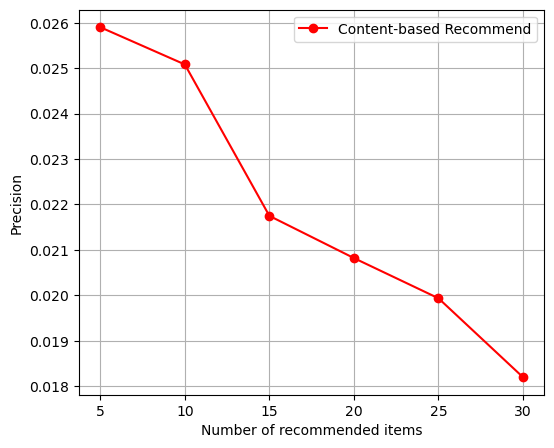

In [91]:
import matplotlib.pyplot as plt
# mae_uibf.append(mae)
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n_list, precision, label="Content-based Recommend", color="red", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [94]:
n_list = [5, 10, 15, 20, 25, 30]
recall = []
for n in n_list:
    hit = 0
    all = 0
    for u, i in test_data.items():
        for v, r in sorted(user_item_sim[u].items(), key=lambda x: x[1], reverse=True)[:n]:
            if v in i:
                hit += 1
        all += len(i)
    recall.append(hit / all)

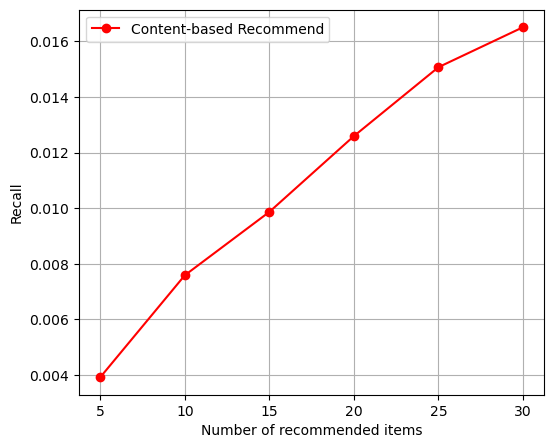

In [96]:
plt.figure(figsize=(6, 5))
plt.grid()
plt.plot(n_list, recall, label="Content-based Recommend", color="red", linestyle="-", marker="o")
plt.xlabel("Number of recommended items")
plt.ylabel("Recall")
plt.legend()
plt.show()